In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH, FIGURES_PATH
from experiments.utils.parser import AdaptationParser
import experiments.utils.drawing

In [2]:
metaseries = 14

series_meta = {
    "video": {"IPA": 11, "FA2-low": 12, "FA2-high": 13, "RIM": 15},
    "audio-qa": {"IPA": 31, "FA2-low": 32, "FA2-high": 33, "RIM": 35},
    "audio-sent": {"IPA": 51, "FA2-low": 52, "FA2-high": 53, "RIM": 55},
    "sum-qa": {"IPA": 71, "FA2-low": 72, "FA2-high": 73, "RIM": 75},
    "nlp": {"IPA": 91, "FA2-low": 92, "FA2-high": 93, "RIM": 95},
}

serie_pipeline = {}
serie_name = {}
for pipeline, series in series_meta.items():
    for name, serie in series.items():
        serie_pipeline[serie] = pipeline
        serie_name[serie] = name


series_paths = {
    series: os.path.join(
        FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series)
    )
    for series in serie_pipeline.keys()
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

# Real Latencies

In [3]:
timeout_per_second = {}
per_second_results = {}
for series in serie_pipeline.keys():
    timeout_per_second[series], per_second_results[series] = loaders[
        series
    ].per_second_result_processing()

In [4]:
metric = "p99"  # [min, max, p99]
metrics_all = {}
for series in serie_pipeline.keys():
    metric_columns = list(
        filter(lambda col: metric in col, per_second_results[series].columns)
    )
    metrics_all[series] = per_second_results[series][metric_columns]
    metrics_all[series] = metrics_all[series].to_dict(orient="list")
ylabel = "Second"
data = {}


for serie, pipeline in serie_pipeline.items():
    if data.get(pipeline) is None:
        data[pipeline] = {}
    data[pipeline][serie] = metrics_all[serie]["e2e_p99"]

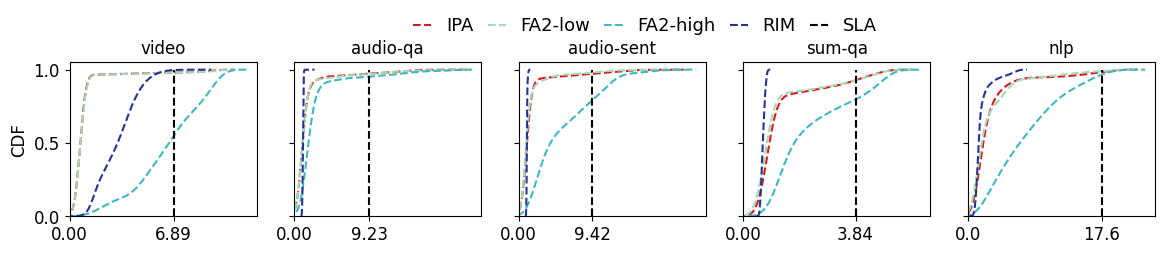

In [5]:
import importlib

importlib.reload(experiments.utils.drawing)
vertical_values = {
    "video": 6.89,
    "audio-qa": 9.23,
    "audio-sent": 9.42,
    "sum-qa": 3.84,
    "nlp": 17.61,
}
serie_color = {
    "IPA": "#d7191c",
    "FA2-low": "#a1dab4",
    "FA2-high": "#41b6c4",
    "RIM": "#253494",
}


experiments.utils.drawing.draw_cdf(
    data,
    serie_name,
    serie_color,
    vertical_values,
    vertical_label="SLA",
    bbox_to_anchor=(-0.4, 1.4),
    filename=f"{FIGURES_PATH}/latency-cdf",
    figsize=(14, 2),
    linear_plot=True,
    num_figs=5,
)